In [12]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.nn.modules import Module
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import sys
model_dir = '/homes/okz21/NNC/models/'
import models 
from utils import test_accuracy, train_epoch, show_weights, layer_utils, print_dims

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)

#Data
train_dataset = dsets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = dsets.MNIST(root='./data', train=False , transform=transforms.ToTensor(), download=True)

num_epochs = 100
batch_size = 256

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=10000, shuffle=False)
use_cuda = torch.cuda.is_available()

## LeNet 300-100

### 1. Train Model

In [2]:
model = models.LeNet_300_100()
print_dims(model)

criterion = nn.CrossEntropyLoss()
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 0.000)

model.cuda()
for epoch in range(num_epochs):
    model, loss = train_epoch(model, optimizer, criterion, train_loader)
    accuracy = test_accuracy(test_loader, model)
    print('Epoch: {}. Loss: {}. Accuracy: {}'.format(epoch+1, loss.data[0], accuracy))

300x784 + 300
100x300 + 100
10x100 + 10


NameError: global name 'criterion' is not defined

In [ ]:
torch.save(model, model_dir + 'mnist_{}_{}.m'.format(model.name, num_epochs))

### 2. Re-train Model

In [2]:
# 1. Load model
# 2. Get new labels, generate new dataset
# 3. New Loss Function
# 4. Freeze Layers
# 5. Train with L2 penalty
# 6. Trim
# 7. Get accuracy

#1 Load Model
model_name = 'LeNet_300_100'
model = torch.load(model_dir + 'mnist_{}_{}.m'.format(model_name, num_epochs)).cuda()
model_wd = torch.load(model_dir + 'mnist_{}_{}_wd.m'.format(model_name, num_epochs)).cuda()

print test_accuracy(test_loader, model)
print test_accuracy(test_loader, model_wd)

show_weights(model)
show_weights(model_wd)

/homes/okz21/.conda/envs/aml/lib/python2.7/site-packages/torch/serialization.py:284: SourceChangeWarning: source code of class 'models.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


AttributeError: 'torch.LongTensor' object has no attribute 'requires_grad'

In [ ]:
#2 Get training traget softmaxes
targets_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=60000, shuffle=False)
for i, (images, labels) in enumerate(targets_loader):
    kd_outputs = model.forward(Variable(images).cuda(),True)

features = torch.zeros(len(train_dataset), train_dataset[0][0].size()[1], train_dataset[0][0].size()[2])
for i in range(0,len(train_dataset)):
    features[i] = train_dataset[i][0][0]
kd_dataset = torch.utils.data.TensorDataset(features, kd_outputs.data)#.data turns variable -> tensor

train_kd_loader = torch.utils.data.DataLoader(dataset=kd_dataset, batch_size=batch_size, shuffle=True)

In [6]:
kd_outputs[0]

Variable containing:
 -6.8751
-19.6925
 -4.9481
 19.9818
-55.0510
 25.2963
-32.4960
-19.7940
-15.9372
-14.2129
[torch.cuda.FloatTensor of size 10 (GPU 0)]

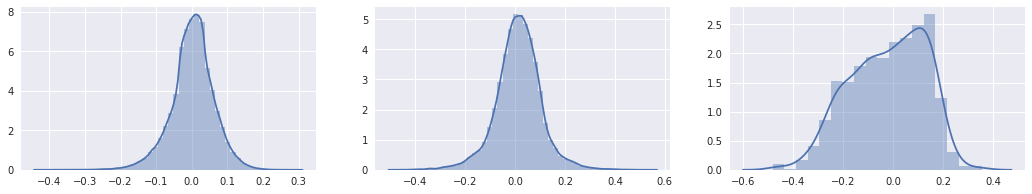

In [20]:
model = torch.load(model_dir + 'mnist_{}_{}.m'.format(model.name, num_epochs)).cuda()

criterion_kd = nn.MSELoss()
ce_loss = nn.CrossEntropyLoss()
learning_rate_kd = 0.0005
wd_kd = 0.01
optimizer_kd_1 = torch.optim.Adam(model.fc1.parameters(), lr=learning_rate_kd, weight_decay = wd_kd)
optimizer_kd_2 = torch.optim.Adam(model.fc2.parameters(), lr=learning_rate_kd, weight_decay = wd_kd)
optimizer_kd_3 = torch.optim.Adam(model.fc3.parameters(), lr=learning_rate_kd, weight_decay = wd_kd)

show_weights(model)
retraining_epochs=10

Epoch: 1. Loss: 0.146734878421. Accuracy: 97.53
Epoch: 2. Loss: 0.2199498564. Accuracy: 97.56
Epoch: 3. Loss: 0.225386634469. Accuracy: 97.54
Epoch: 4. Loss: 0.201133444905. Accuracy: 97.57
Epoch: 5. Loss: 0.187315449119. Accuracy: 97.55
Epoch: 6. Loss: 0.164713516831. Accuracy: 97.54
Epoch: 7. Loss: 0.179824605584. Accuracy: 97.56
Epoch: 8. Loss: 0.160107091069. Accuracy: 97.58
Epoch: 9. Loss: 0.240297496319. Accuracy: 97.53
Epoch: 10. Loss: 0.259744048119. Accuracy: 97.6


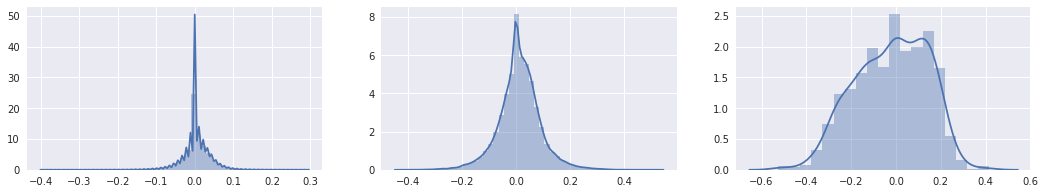

In [24]:
for epoch in range(retraining_epochs):
    model, loss = train_epoch(model, optimizer_kd_3, criterion_kd, train_kd_loader, kd=True)
    model, loss = train_epoch(model, optimizer_kd_2, criterion_kd, train_kd_loader, kd=True)
    model, loss = train_epoch(model, optimizer_kd_1, criterion_kd, train_kd_loader, kd=True)
    accuracy = test_accuracy(test_loader, model, ce_loss, kd=True)
    print('Epoch: {}. Loss: {}. Accuracy: {}'.format(epoch+1, loss.data[0], accuracy))
show_weights(model)